<a href="https://colab.research.google.com/github/Tharunakula/Home-Assignment-5/blob/main/Basic%20GAN%20Implementation%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [0/101], Step [200/469], D Loss: 0.1499, G Loss: 3.4208
Epoch [0/101], Step [400/469], D Loss: 0.0910, G Loss: 3.5564
Epoch [1/101], Step [200/469], D Loss: 0.1060, G Loss: 5.8190
Epoch [1/101], Step [400/469], D Loss: 0.0916, G Loss: 6.4033
Epoch [2/101], Step [200/469], D Loss: 0.0092, G Loss: 5.5017
Epoch [2/101], Step [400/469], D Loss: 0.0120, G Loss: 6.2456
Epoch [3/101], Step [200/469], D Loss: 0.0029, G Loss: 10.2162
Epoch [3/101], Step [400/469], D Loss: 0.0006, G Loss: 8.0799
Epoch [4/101], Step [200/469], D Loss: 0.0004, G Loss: 8.7434
Epoch [4/101], Step [400/469], D Loss: 0.0030, G Loss: 9.6934
Epoch [5/101], Step [200/469], D Loss: 0.0020, G Loss: 7.5231
Epoch [5/101], Step [400/469], D Loss: 0.0001, G Loss: 10.3132
Epoch [6/101], Step [200/469], D Loss: 0.0000, G Loss: 11.5439
Epoch [6/101], Step [400/469], D Loss: 0.0000, G Loss: 11.5394
Epoch [7/101], Step [200/469], D Loss: 0.0000, G Loss: 11.8542
Epoch [7/101], Step [400/469], D Loss: 0.0000, G Loss: 12.0278
Ep

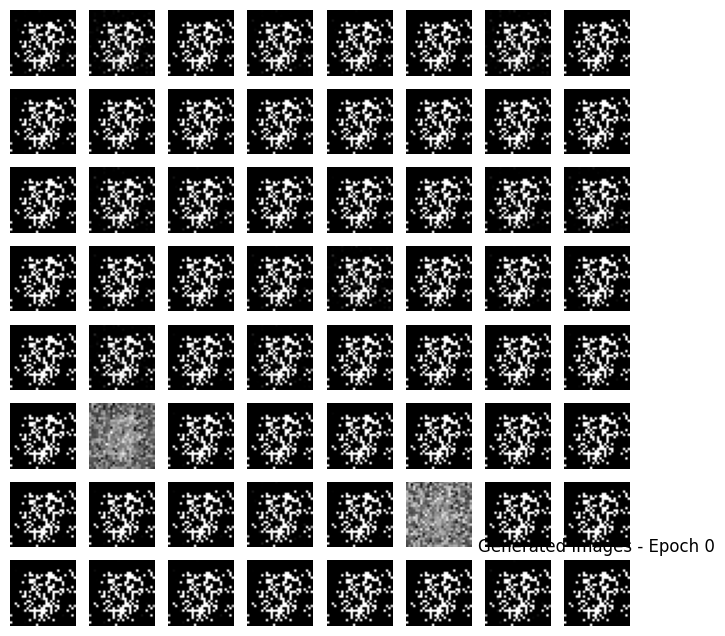

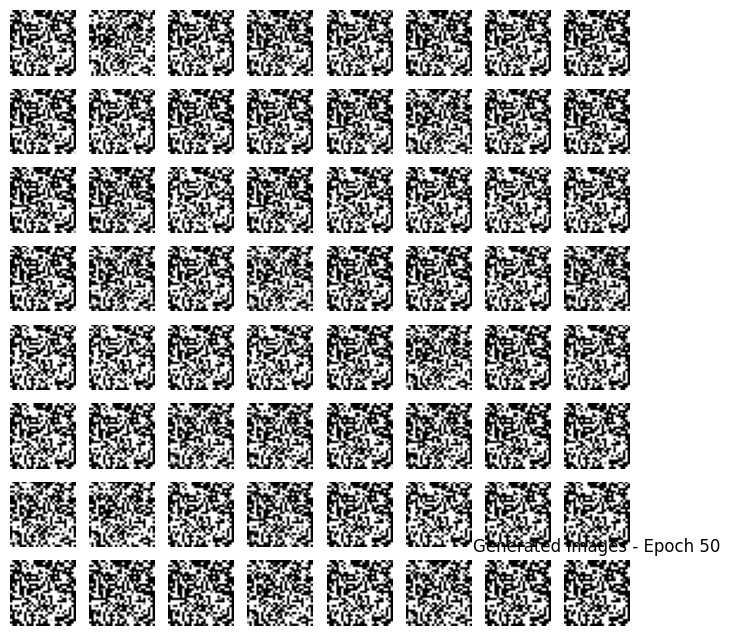

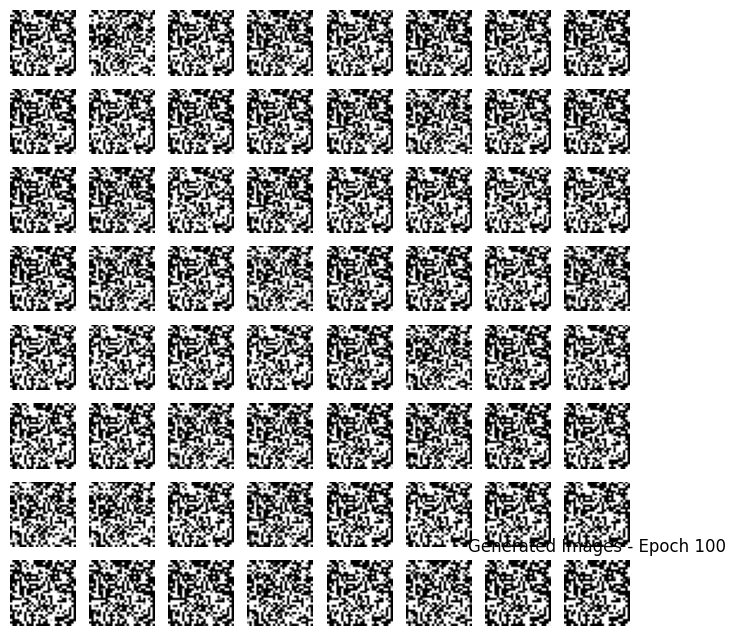

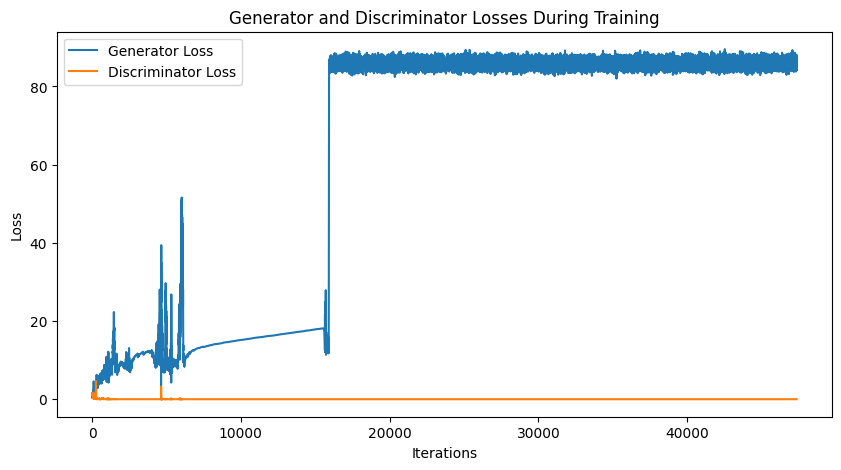

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define hyperparameters
latent_dim = 100
image_size = 784  # 28x28
batch_size = 128
epochs = 101
learning_rate = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# -------------------- Generator Architecture --------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, image_size),
            nn.Tanh()  # Output in [-1, 1] to match normalized MNIST
        )

    def forward(self, input):
        return self.main(input).view(-1, 1, 28, 28)

# -------------------- Discriminator Architecture --------------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability (real or fake)
        )

    def forward(self, input):
        # Flatten the input image
        input = input.view(input.size(0), -1)
        return self.main(input)

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Fixed noise for visualizing generated samples
fixed_noise = torch.randn(64, latent_dim, device=device)

# Lists to store losses for plotting
generator_losses = []
discriminator_losses = []
image_list = []

# -------------------- Training Loop --------------------
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device).view(-1, image_size)
        batch_size = real_images.size(0)

        # -------------------- Update Discriminator --------------------
        optimizer_d.zero_grad()

        # Real data loss
        label_real = torch.ones(batch_size, 1, device=device)
        output_real = discriminator(real_images)
        loss_real = criterion(output_real, label_real)

        # Fake data loss
        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_images = generator(noise)
        label_fake = torch.zeros(batch_size, 1, device=device)
        output_fake = discriminator(fake_images.detach())  # Detach to avoid generator gradients
        loss_fake = criterion(output_fake, label_fake)

        # Total discriminator loss
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

        # -------------------- Update Generator --------------------
        optimizer_g.zero_grad()

        # Generator tries to fool the discriminator
        label_real_for_gen = torch.ones(batch_size, 1, device=device)
        output_fake_gen = discriminator(fake_images)
        loss_g = criterion(output_fake_gen, label_real_for_gen)
        loss_g.backward()
        optimizer_g.step()

        # Store losses
        generator_losses.append(loss_g.item())
        discriminator_losses.append(loss_d.item())

        # Print progress
        if (i + 1) % 200 == 0:
            print(f"Epoch [{epoch}/{epochs}], Step [{i+1}/{len(train_loader)}], "
                  f"D Loss: {loss_d.item():.4f}, G Loss: {loss_g.item():.4f}")

    # Generate and save sample images at specific epochs
    if epoch == 0 or epoch == 50 or epoch == 100:
        with torch.no_grad():
            fake_samples = generator(fixed_noise).cpu()
            image_list.append(fake_samples)

# -------------------- Display Generated Images --------------------
def show_images(images, epoch):
    fig = plt.figure(figsize=(8, 8))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        plt.axis('off')
    plt.title(f"Generated Images - Epoch {epoch}")
    plt.show()

if len(image_list) > 0:
    if epochs > 0:
        show_images(image_list[0], 0)
    if epochs > 50:
        show_images(image_list[1], 50)
    if epochs > 100:
        show_images(image_list[2], 100)

# -------------------- Plotting Losses --------------------
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses During Training')
plt.legend()
plt.show()

# You can take a screenshot of the generated images and the loss plot.